# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: HTR with User Data 

In [1]:
pip list | grep spot

pyspot                                    0.0.1
pyspotriver                               0.0.3
pyspotstream                              0.2.0
spotPython                                0.0.6
spotRiver                                 0.0.8
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall http://www.gm.fh-koeln.de/~bartz/site/spotPython.tar.gz

## Example 1: HTR Hyperparameter

In [3]:
import numpy as np
from math import inf
from spotRiver.fun.hyperriver import HyperRiver
from spotPython.spot import spot
from spotRiver import data
from scipy.optimize import shgo
from scipy.optimize import direct
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

### 1 The Objective Function 

* Here we will use the river `HATR` function.
* First, the function will be tested independently from `Spot`.

In [4]:
import numpy as np
import datetime as dt
from river import datasets
from river import time_series
from river import utils
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import metrics
from spotRiver.fun.hyperriver import HyperRiver

fun = HyperRiver(123).fun_HTR_iter_progressive
var_type = ["int"] * 2 + ["num"] * 2 + ["factor"] + ["float"] + ["int"] * 2 + ["factor"] + ["float"]
var_type



['int',
 'int',
 'num',
 'num',
 'factor',
 'float',
 'int',
 'int',
 'factor',
 'float']

### 2 The `fun_snarimax` from `spotPython`'s `HyperRiver` class

* Next, we use the implementation of the function from the `HyperRiver` class.
* Twelve hyperparameters to be optimized. Here:

0. `p` (int):
    Order of the autoregressive part.
    This is the number of past target values that will be included as features.
1. `d` (int):
    Differencing order.
2. `q` (int):
    Order of the moving average part.
    This is the number of past error terms that will be included as features.
3. `m` (int):
    Season length used for extracting seasonal features.
    If you believe your data has a seasonal pattern, then set this accordingly.
    For instance, if the data seems to exhibit a yearly seasonality,
    and that your data is spaced by month, then you should set this to `12`.
    Note that for this parameter to have any impact you should also set
    at least one of the `p`, `d`, and `q` parameters.
4. `sp` (int):
    Seasonal order of the autoregressive part.
    This is the number of past target values that will be included as features.
5. `sd` (int):
    Seasonal differencing order.
6. `sq`(int):
    Seasonal order of the moving average part.
    This is the number of past error terms that will be included as features.
7. `lr` (float):
    learn rate of the linear regression model. A river `preprocessing.StandardScaler`
    piped with a river `linear_model.LinearRegression` will be used.
8. `intercept_lr` (float): intercept of the the linear regression model.
    A river `preprocessing.StandardScaler` piped with a river `linear_model.LinearRegression`
    will be used.
9. `hour` (bool): If `True`, an hourly component is added.
10. `weekday` (bool): If `True`, an weekday component is added.
11. `month` (bool): If `True`, an monthly component is added.

* Note: Instead of using the Airline Passenger data as in notebook 01, we demonstrate the usage of user specified data which is *not* part of the `spotRiver` package!
* Remember: Previously, we used the setting, which will be overwritten in the following steps.

In [5]:
#                 p, d, q, m, sp, sd, sq, lr, intercept_lr, hour, weekday, month:
# lower = np.array([0, 0, 0, 1, 0,  0,  0,   0.00225, 0.05,   0,        0,   0])
# upper = np.array([1, 1, 1, 24, 1,  1,   1,  0.0025, 0.1,    0,        0,   1])
# fun_control = {"horizon": 12,
#                "grace_period": None,
#                "data": dataset,
#                }

## User Specified Data

In [6]:
# from pyspotstream.datasets import fetch_opm
# ds = fetch_opm(include_categorical=False, data_home="data", return_X_y=True)

* Important: Specify the location of your data, e.g., `/home/data/` etc.

In [7]:
from spotRiver.data.generic import GenericData
dataset = GenericData(filename="opm_cat.csv",
                      directory=".",
                      target="Sale Amount",
                      n_features=14,
                      n_samples=195_832,
                      fraction = 0.1,
                      converters={'List Year': int,
                                  'Assessed Value': float,
                                  'Sale Amount': float,
                                  'Sales Ratio': float,
                                  'lon': float,
                                  'lat': float,
                                  'timestamp_rec': float},
                      parse_dates=None
                      # parse_dates={"Date Recorded": "%Y-%m-%d"}
                      )
n_samples = dataset.n_samples

# CHECK Data Set

In [8]:
# from river.datasets import synth
# dataset = synth.Friedman(seed=42).take(100_000)
# n_samples = 500_000

In [9]:
for x,y in dataset:
    print(x,y)
    break

{'List Year': 2001, 'Assessed Value': 50720.0, 'Sales Ratio': 0.878268398, 'lat': 41.50021401170393, 'lon': -72.87396263711757, 'timestamp_rec': 1001894400.0, 'Town': 'New Britain', 'Address': '135 GOLD ST', 'Property Type': 'Unknown', 'Residential Type': 'Unknown', 'Non Use Code': 'Unknown', 'Assessor Remarks': 'Unknown', 'OPM remarks': 'Unknown'} 57750.0


In [10]:
# [[2.00e+02 1.00e+01 1.00e-06 7.50e-02 2.00e+00 1.00e+00 0.00e+00 7.00e+00 0.00e+00 3.12e+02]]
lower = np.array([100, 2,  1e-8, 0.025, 0, 0.8,  0,  3, 0, 250.0])
upper = np.array([200, 10, 1e-6, 0.075, 1, 0.975, 1, 7, 1, 750.0])
fun_control = {"data": dataset,
               "n_samples": n_samples}

### 3 Run the `Spot` Optimizer

* Since the data is larger than the airline passengers data, the max. time is increased.

In [11]:
spot_htr = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 1,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type=var_type,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 20,
                                   "repeats": 1},
                   surrogate_control={"noise": False,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": 10,
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 1000,
                                      })
spot_htr.run()

spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/spotPython/build/kriging.py:847: RuntimeWarning: invalid value encountered in scalar divide
  X[i] = (X[i] - self.nat_range_X[i][0]) / float(self.nat_range_X[i][1] - self.nat_range_X[i][0])


spotPython tuning: [##########] 100.00% Done...


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/spotPython/build/kriging.py:847: RuntimeWarning: invalid value encountered in scalar divide
  X[i] = (X[i] - self.nat_range_X[i][0]) / float(self.nat_range_X[i][1] - self.nat_range_X[i][0])


spotPython tuning: [##########] 100.00% Done...


/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/spotPython/build/kriging.py:847: RuntimeWarning: invalid value encountered in scalar divide
  X[i] = (X[i] - self.nat_range_X[i][0]) / float(self.nat_range_X[i][1] - self.nat_range_X[i][0])


spotPython tuning: [##########] 100.00% Done...


### 4 Results 

* Print the Results

In [12]:
spot_htr.print_results()

min y: 0.45509514849911364
min X: [[1.39000000e+02 1.00000000e+01 8.80965687e-07 3.95493298e-02
  1.00000000e+00 1.00000000e+00 0.00000000e+00 5.00000000e+00
  1.00000000e+00 6.29000000e+02]]


* Show the Progress

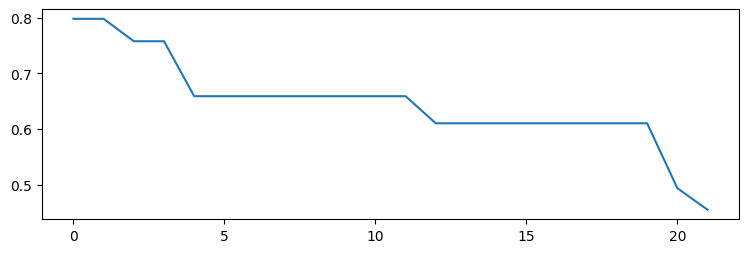

In [13]:
spot_htr.plot_progress(log_y=False)

In [14]:
spot_htr.print_importance()

Importance relative to the most important parameter:
Parameter 0 :  1e-05
Parameter 1 :  0.11204679645085469
Parameter 2 :  1e-05
Parameter 3 :  13.776276491893789
Parameter 4 :  99.99928587078747
Parameter 5 :  0.43398364151181745
Parameter 6 :  100.0
Parameter 7 :  0.21120200076185772
Parameter 8 :  1.0000021482654815e-05
Parameter 9 :  0.03814196288941074


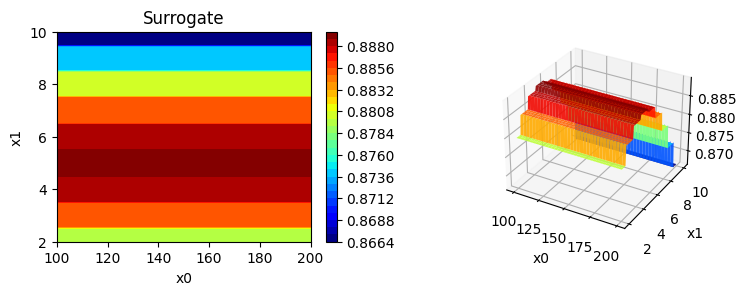

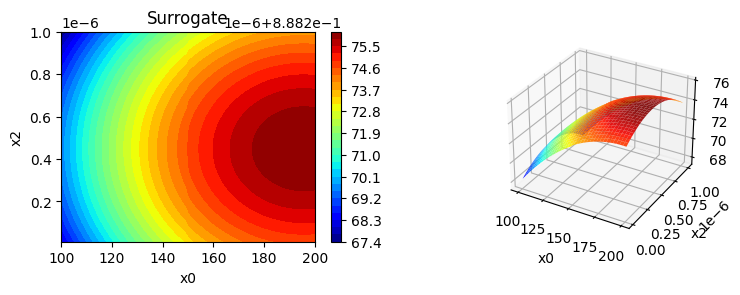

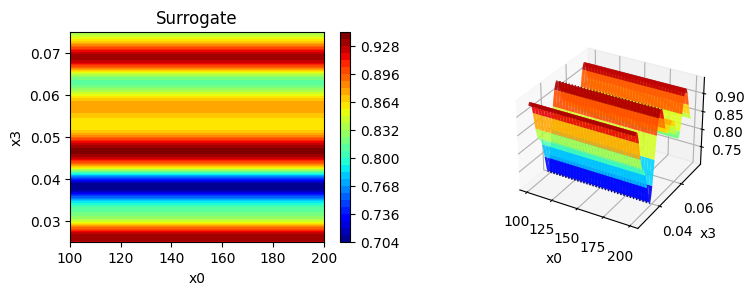

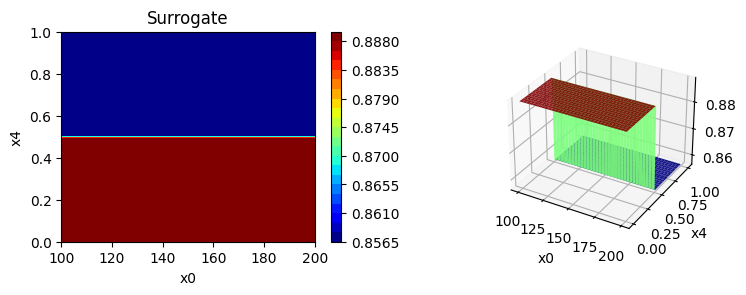

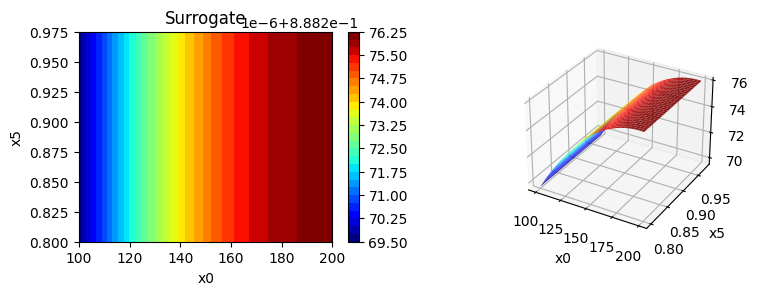

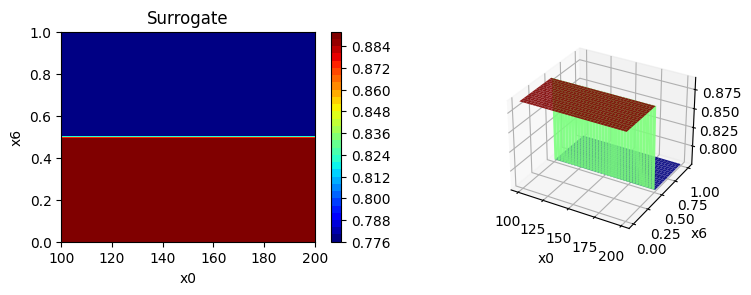

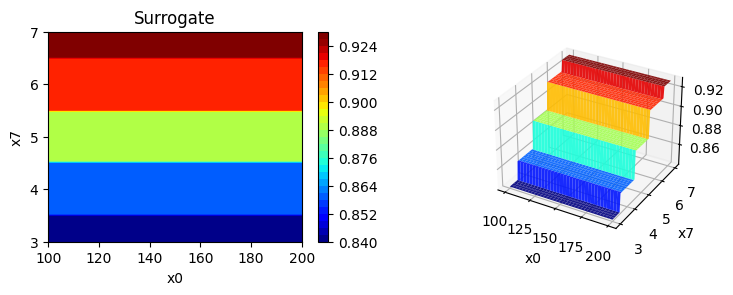

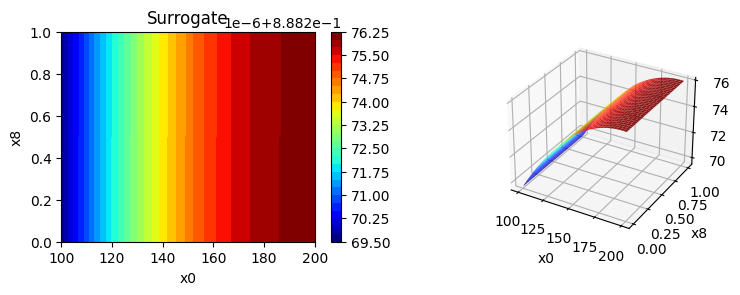

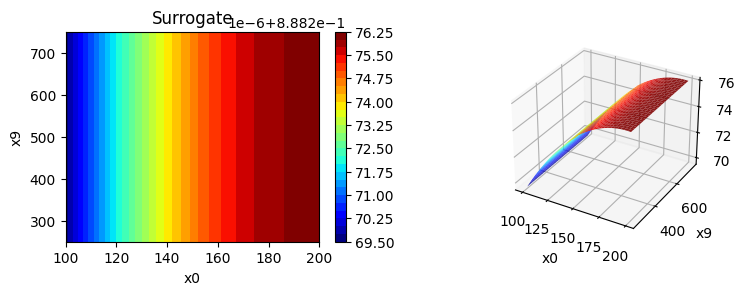

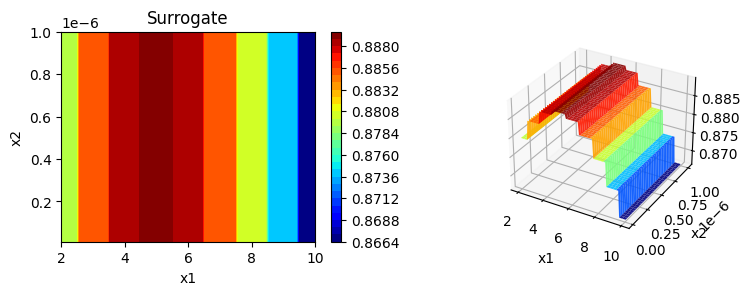

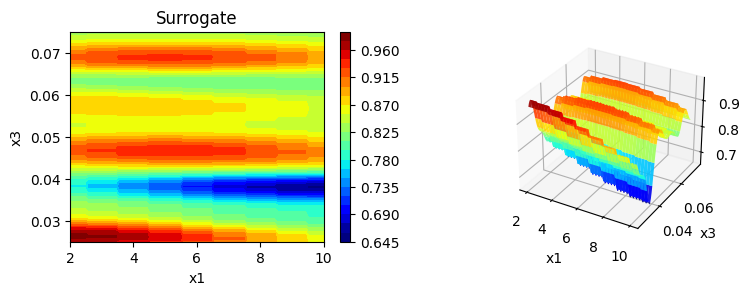

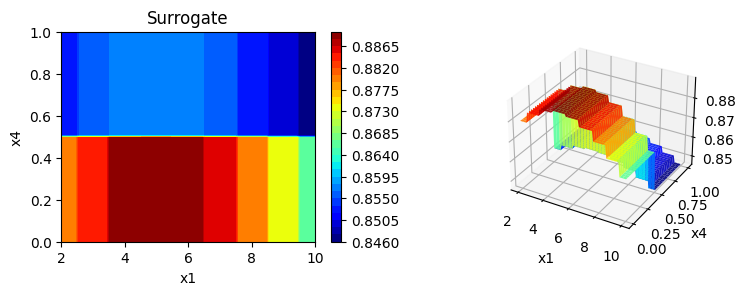

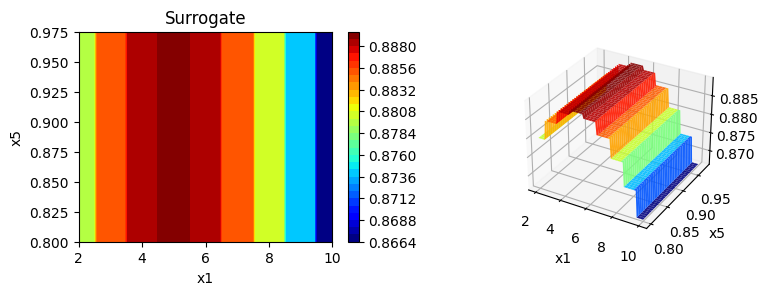

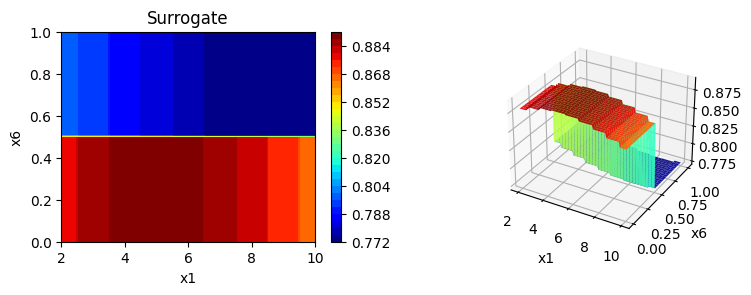

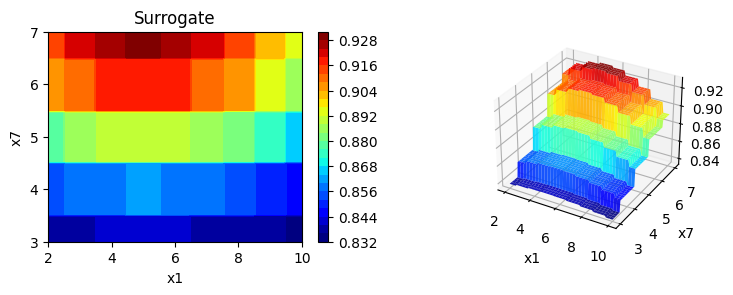

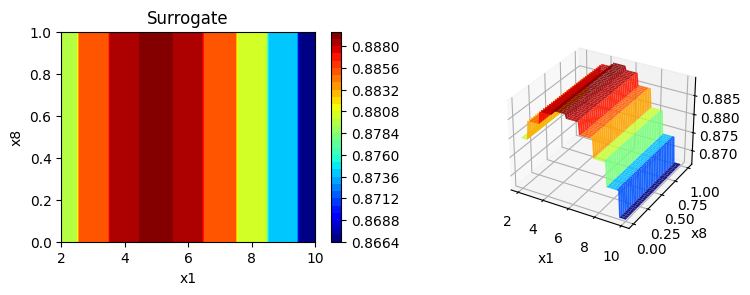

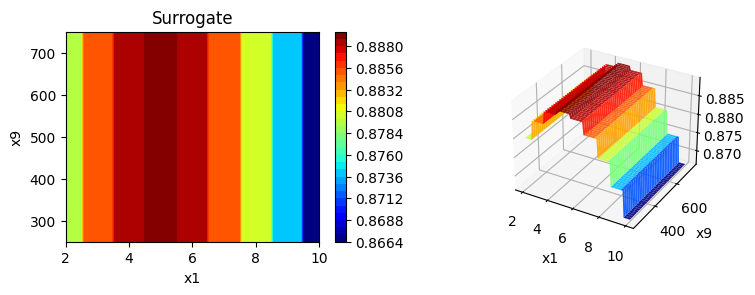

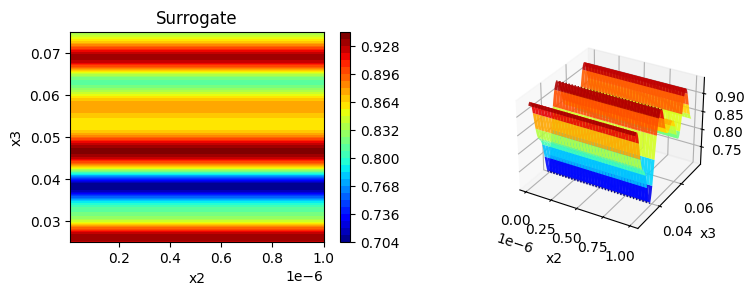

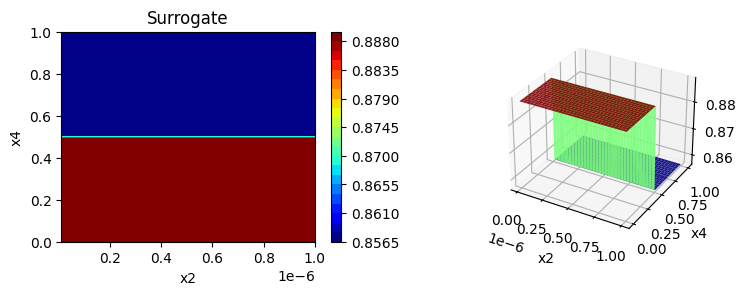

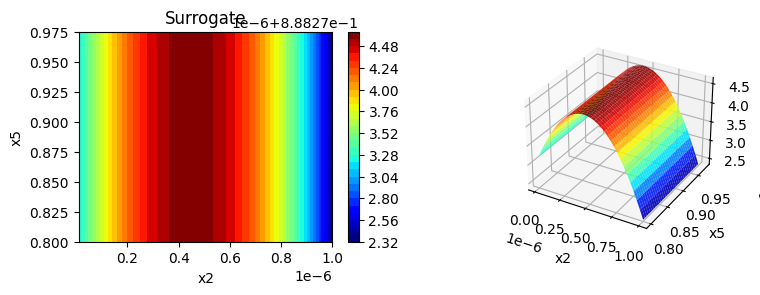

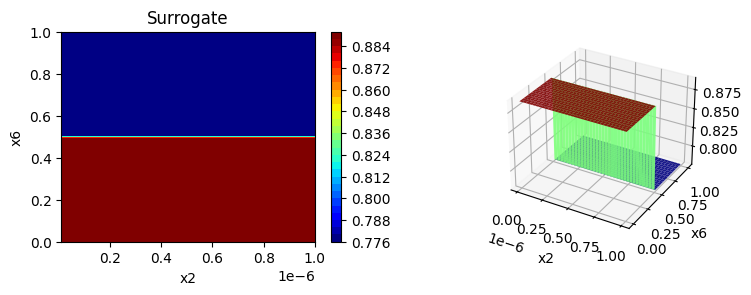

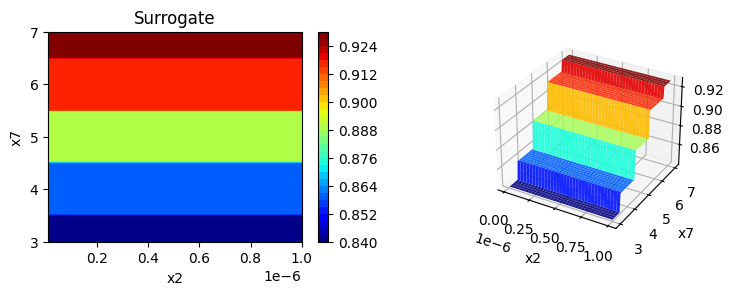

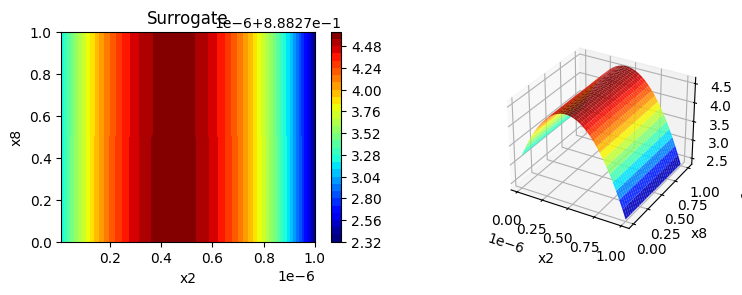

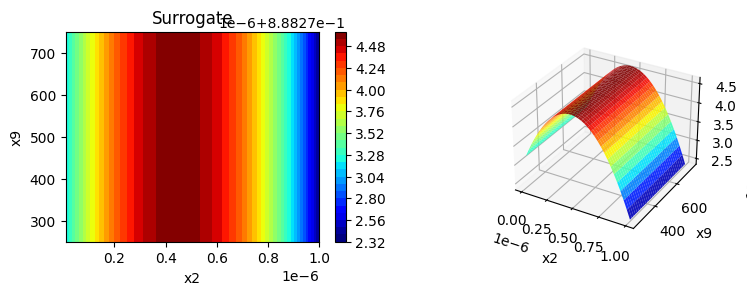

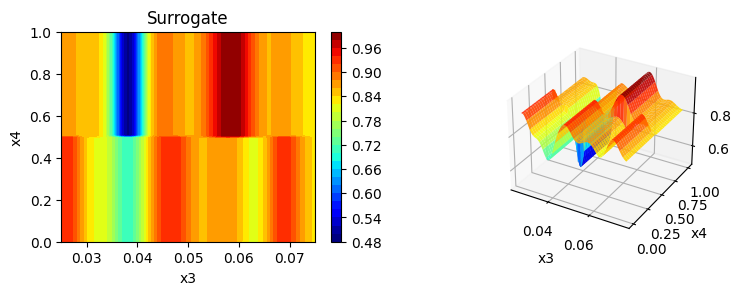

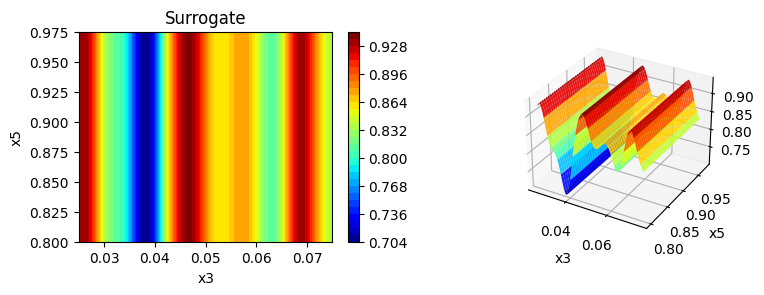

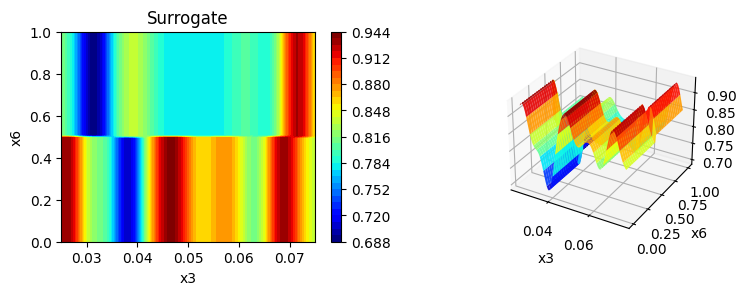

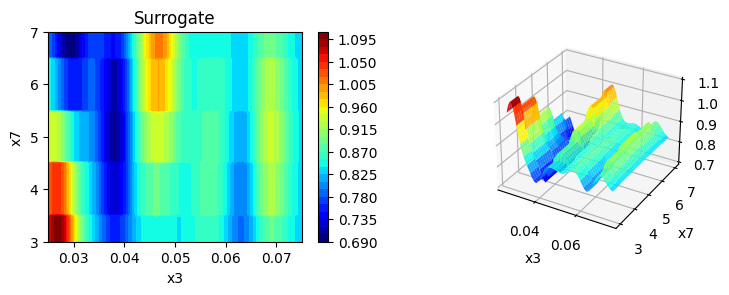

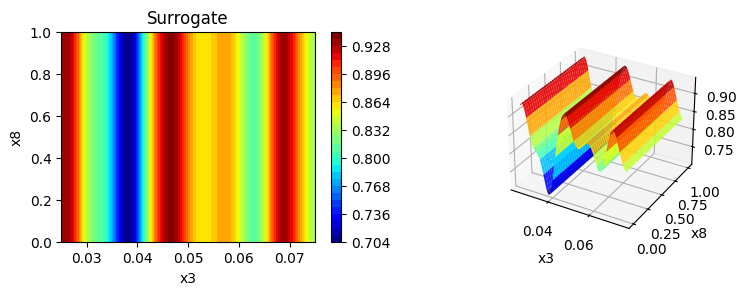

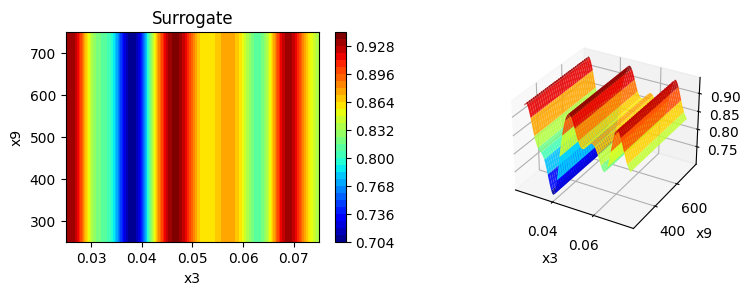

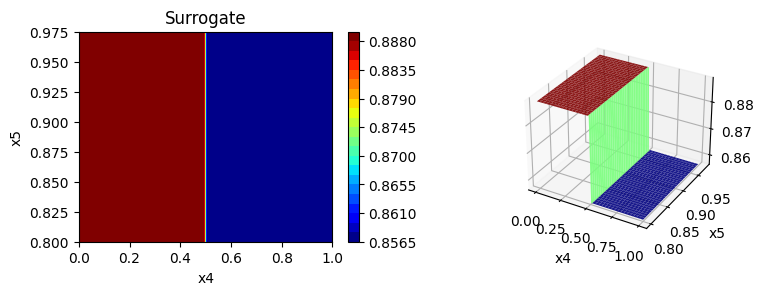

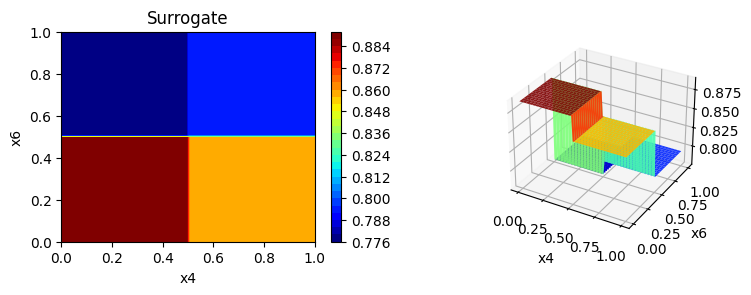

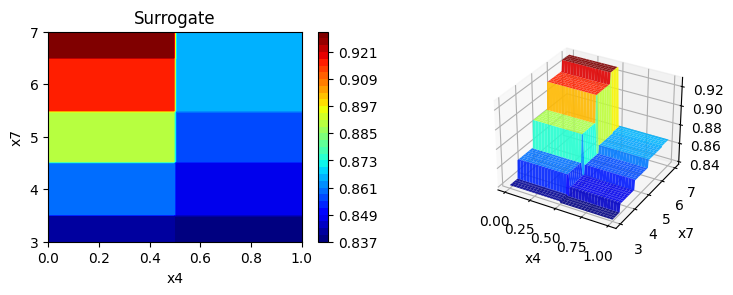

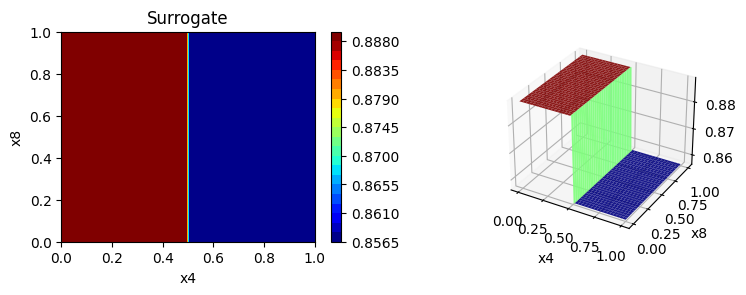

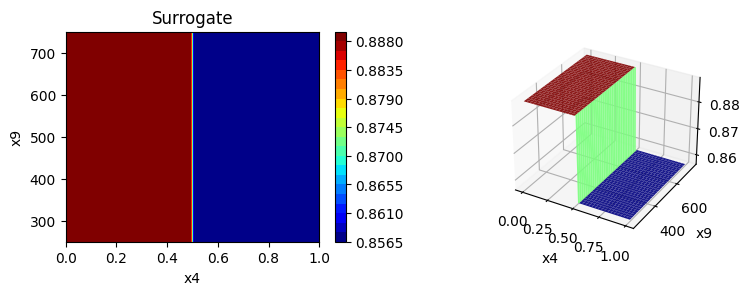

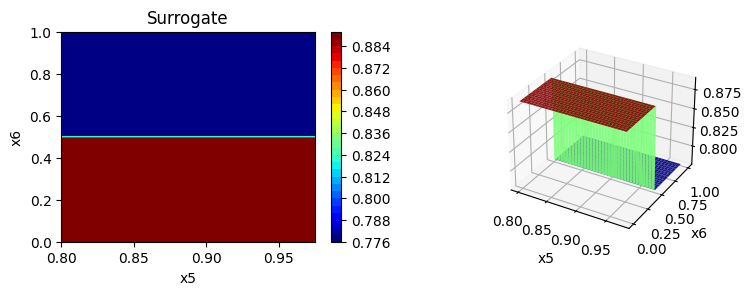

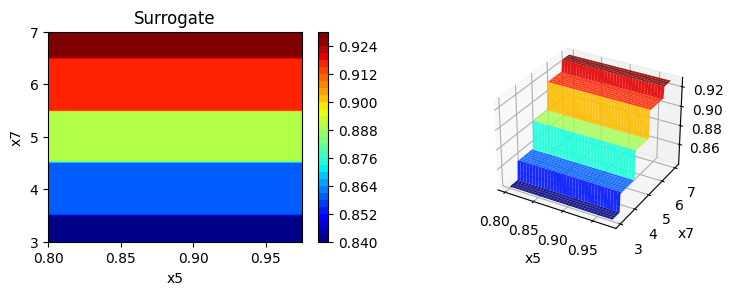

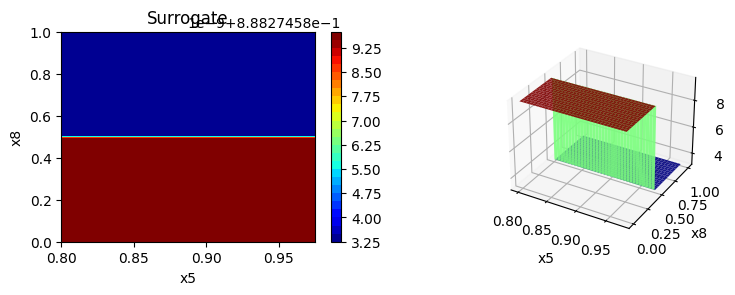

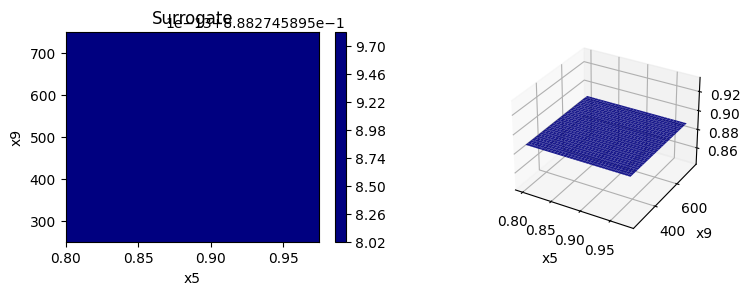

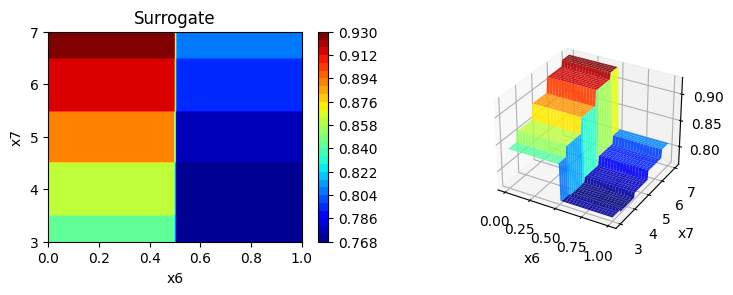

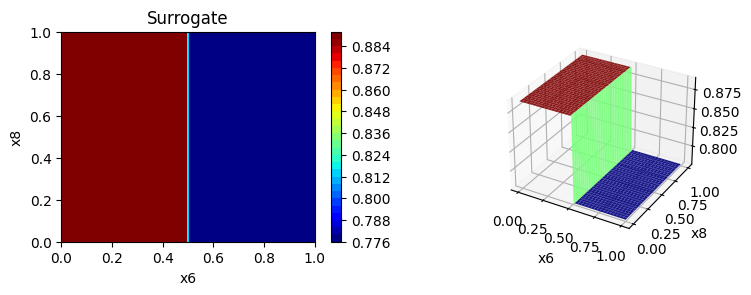

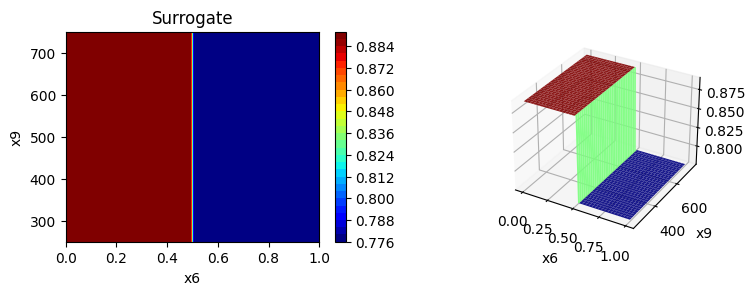

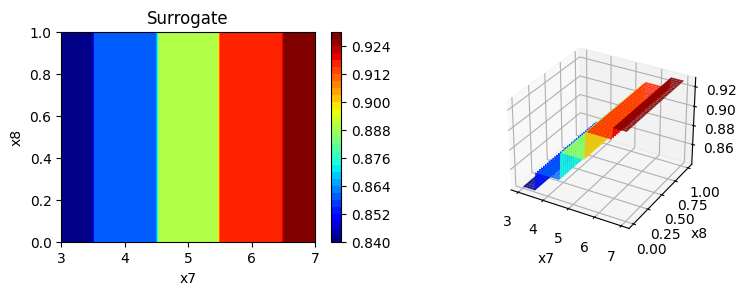

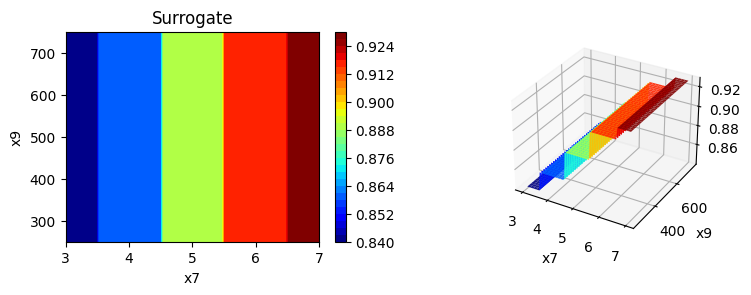

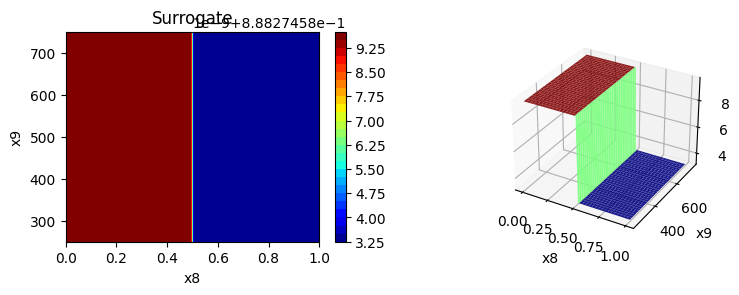

In [15]:
n = spot_htr.k
for i in range(n-1):
    for j in range(i+1, n):
        spot_htr.plot_contour(i=i, j=j)

## Build and Evaluate SNARIMAX Model with Tuned Hyperparameters

In [16]:
X = spot_htr.to_all_dim(spot_htr.min_X.reshape(1,-1))
print(X)
grace_period = X[:, 0]
max_depth = X[:, 1]
delta = X[:, 2]
tau = X[:, 3]
leaf_prediction = X[:, 4]
model_selector_decay = X[:, 5]
splitter = X[:, 6]
min_samples_split = X[:, 7]
binary_split = X[:, 8]
max_size = X[:, 9]


[[1.39000000e+02 1.00000000e+01 8.80965687e-07 3.95493298e-02
  1.00000000e+00 1.00000000e+00 0.00000000e+00 5.00000000e+00
  1.00000000e+00 6.29000000e+02]]


In [17]:
import numbers
from river import tree
from spotRiver.evaluation.eval_oml import fun_eval_oml_iter_progressive
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive
from spotRiver.utils.selectors import select_splitter
num = compose.SelectType(numbers.Number) | preprocessing.StandardScaler()
cat = compose.SelectType(str) | preprocessing.FeatureHasher(n_features=1000, seed=1)
leaf_prediction_list = ["mean", "model", "adaptive"]
res = eval_oml_iter_progressive(
    dataset=fun_control["data"],
    step=10000,
    verbose=True,
    metric=metrics.MAE(),
    models={
         "Default: HTR + QO": (
             (num + cat) | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),
        "SPOT: HTR + QO": (
            (num + cat) | tree.HoeffdingTreeRegressor(
                grace_period=int(grace_period),
                max_depth=int(max_depth),
                delta=float(delta),
                tau=float(tau),
                leaf_prediction=leaf_prediction_list[int(leaf_prediction)],
                splitter=select_splitter(int(splitter)),
                min_samples_split=int(min_samples_split),
                binary_split=int(binary_split),
                max_size=float(max_size)
            )
        ),
    }
)
y = fun_eval_oml_iter_progressive(res, metric=None)

spotPython tuning: [##########] 100.00% Done...
spotPython tuning: [##########] 100.00% Done...


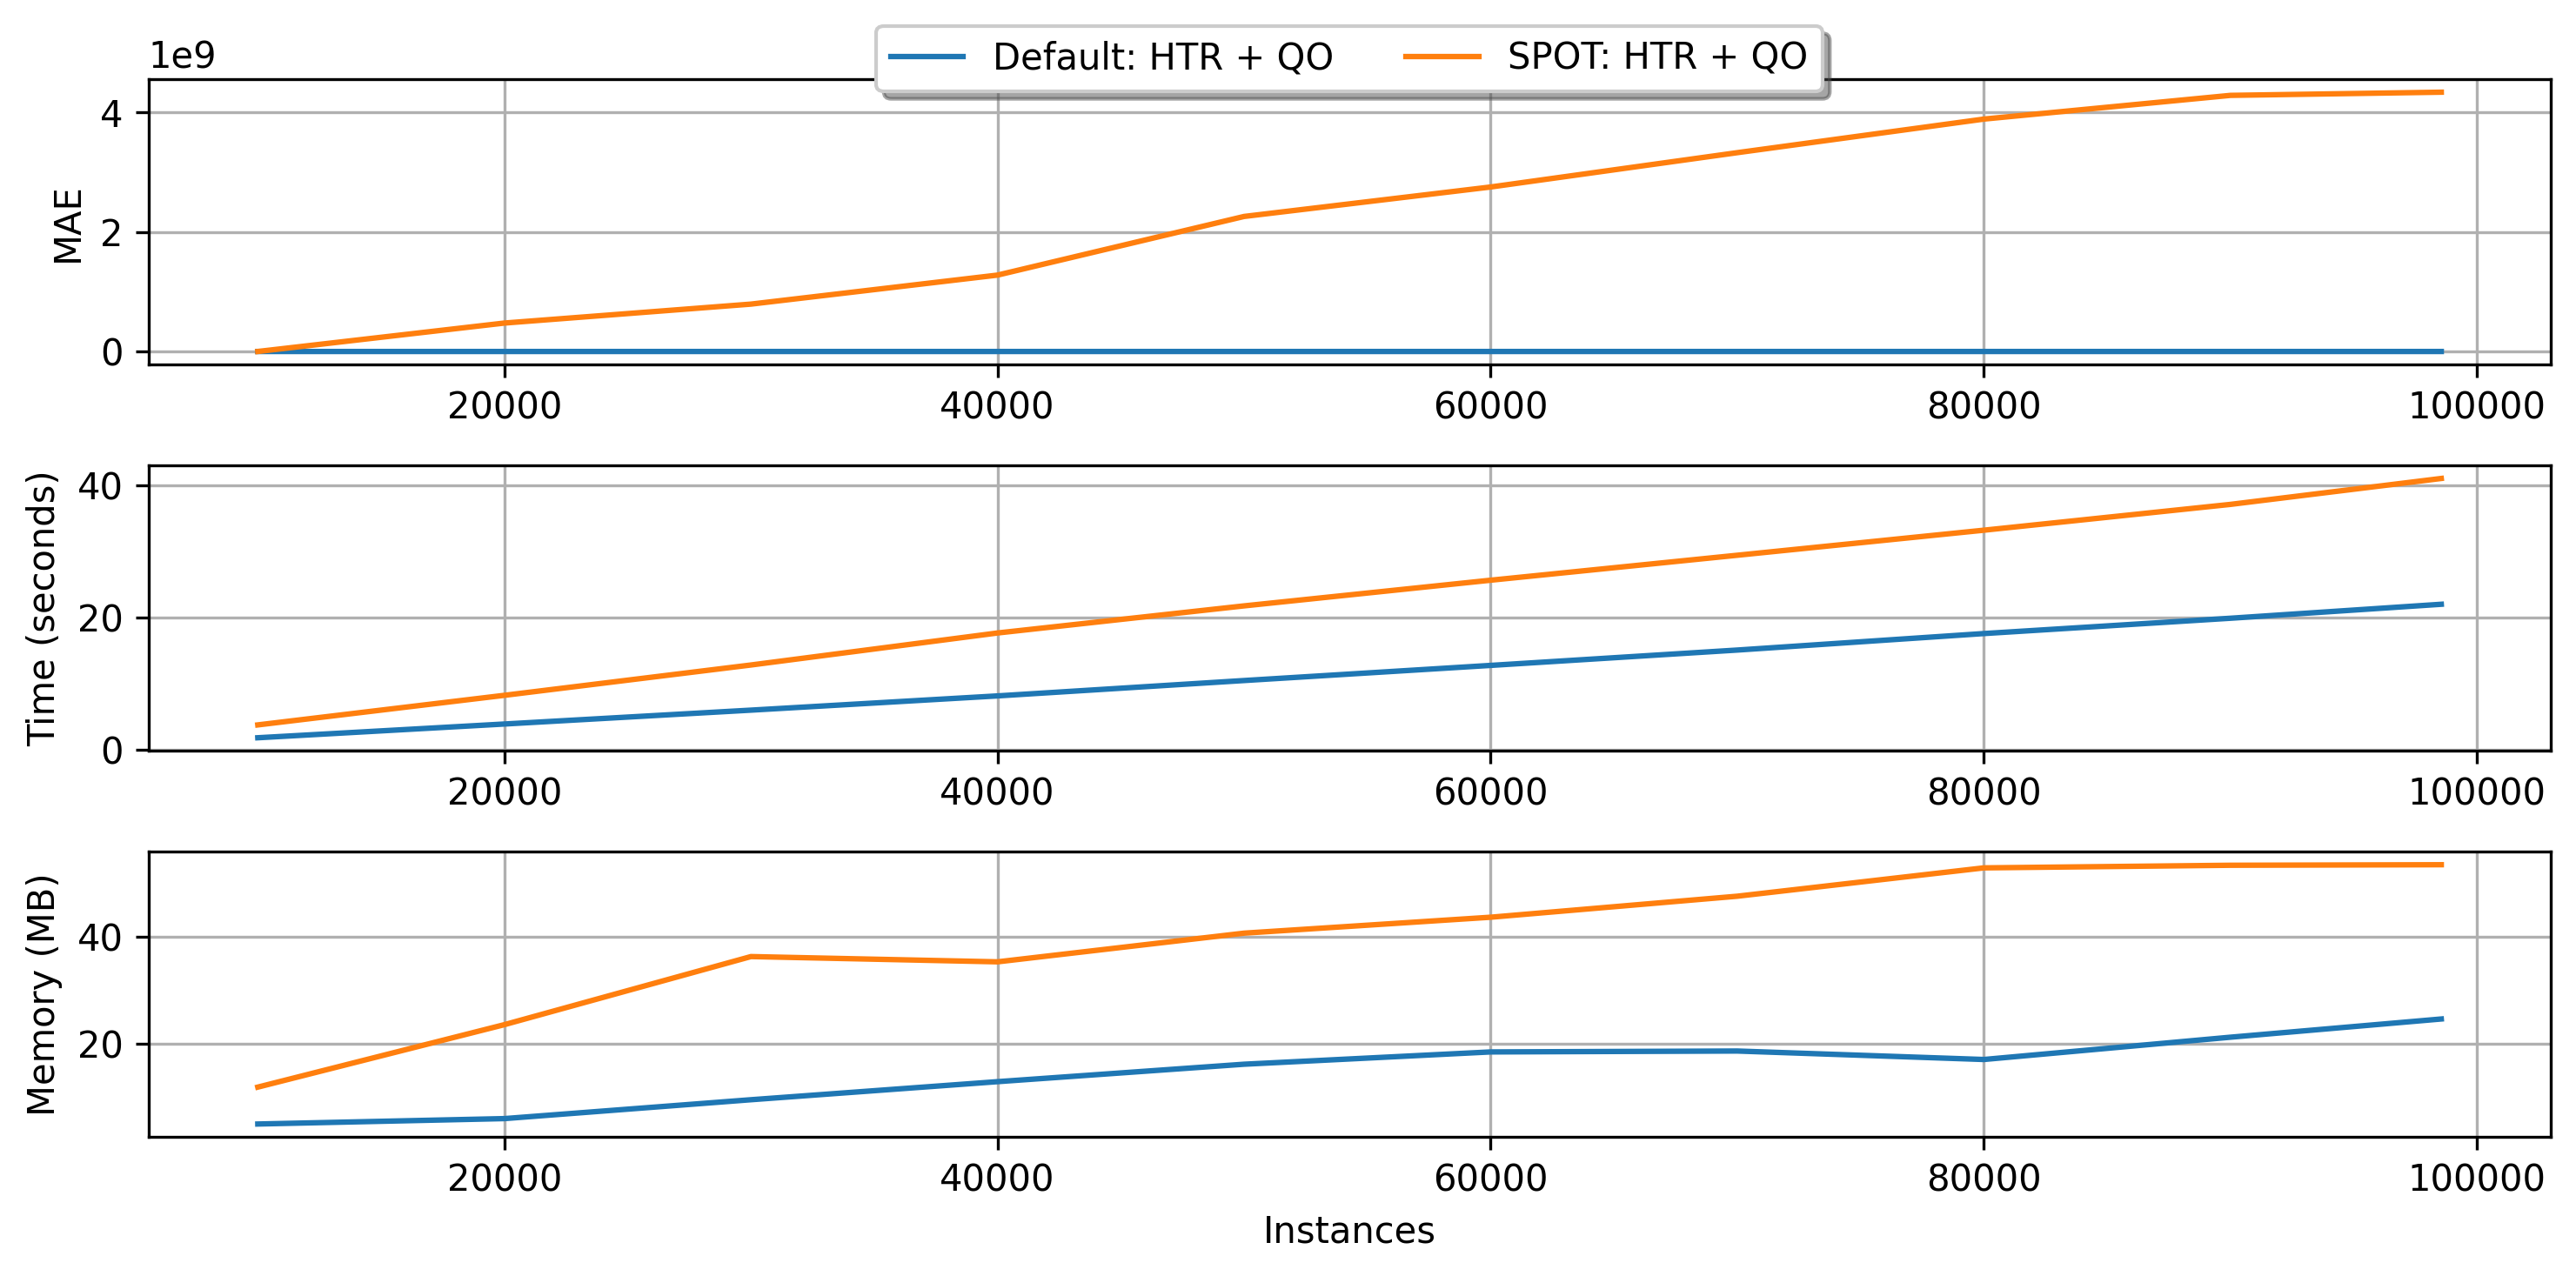

In [18]:
from spotRiver.evaluation.eval_oml import plot_oml_iter_progressive
plot_oml_iter_progressive(res)

In [19]:
# model
# model["ts"].regressor["lm"].weights
# forecast = model.forecast(horizon=fun_control["horizon"])
# forecast
